<h1 align="center">Deep Thought: Was LeBron James the best NBA player during 2013 season?</h1>

<h5 align="center">Amit Klinger: klingeramit@gmail.com</h5>
<h5 align="center">Guy Gozlan: gozlang1@gmail.com</h5>

![](https://target.scene7.com/is/image/Target/GUEST_ae1dac87-cc0b-4758-8f6a-b2d864260eda?wid=488&hei=488&fmt=pjpeg) 
![](https://upload.wikimedia.org/wikipedia/en/3/37/Jumpman_logo.svg)

In [1]:
# Import packages
import pandas as pd
import numpy as np
from sklearn import linear_model
import requests
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup

In [2]:
import scipy
import emcee
import numba
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from corner import corner 
from termcolor import colored

sns.set()
current_palette = sns.color_palette()

### Table of Contents:
    1. Abstract
    2. Data Exploration for single year
    3. Positional-PER (pPER): New approach for selecting MVP
     3.1. Naive pPER exploration
    4. Finding model parameters
     4.1. LR Model for mean PER vs. Year
        4.1.1. Naive approach
        4.1.2. Advanced approach: Per position mean PER
     4.2. pPER for all years
     4.1. Bayesian Inference single parameter: Uniform prior
     4.2. Bayesian Inference single parameter: Normal prior
     4.3. Bayesian Inference two parameters: Uniform prior
     4.4. Bayesian Inference two parameters: Normal prior
     4.5. MCMC 3d
     4.6. Scipy optimization using fmin
     4.7. ABC
    5. Model Evalution of Adjusted PER
         5.1. Single year (2017) evalution
         5.2. Comparison of MVP vs. aMVP 
    6. Conclusions
    
***
***

## Abstract

This is one of the most debatable questions that arises each year is for sure the question of who is the Most Valuable Player in the NBA.

The [Most Valuable Player (MVP)](https://en.wikipedia.org/wiki/NBA_Most_Valuable_Player_Award) award is decided by a panel of sportswriters and broadcasters throughout the United States and Canada. The player with the highest point total wins the award.

This selection might be biased as emotions might effect the sportwriters' decision instead of analytic facts and measureable statistics.

In this work, we would like to propuse new inovative method for selecting the MVP.

***

Currently the main single statistics that sportswriters and broadcasters based their vote is PER.

The [player efficiency rating (PER)](https://en.wikipedia.org/wiki/Player_efficiency_rating) is John Hollinger's all-in-one basketball rating, which attempts to boil down all of a player's contributions into one number.

The PER formula is the following:

![](https://squared2020.files.wordpress.com/2017/09/screen-shot-2017-09-01-at-8-17-08-pm.png) $\quad (1)$
![](https://squared2020.files.wordpress.com/2017/09/screen-shot-2017-09-01-at-11-22-07-am.png) $\quad (2)$

Finally we get:

![](https://squared2020.files.wordpress.com/2017/09/screen-shot-2017-09-01-at-11-24-24-am.png) $\quad (3)$

We would not get into the entire mathematical calculation and different adjustments that were made throughout the years.

This PER metric has some drawbacks, the main one would be that it does not take into account the position of the player on the floor.

We would like to suggest another adjustement on the PER metric to solve that. We call that new metric Positional-PER (pPER).

This metric would help to distinct a dominance of a player with regards to his position on the floor, compared to fellow players on the same position.

This metric, we believe, indicates best the player that shall be elected to be the Most Valuable Player.

In addition, the pPER can help college scouts to select draftees in the upcoming NBA draft as most teams seek a specific position in a given year. For example, in 1984 the Huston Rockets selected first Hakeem Olajuwon as they needed a Center (the best player from this draft is of course the SG Michael Jordan).
***

**pPER formula:**

$$
pPER = \frac{PER - \mu}{\sigma}  \quad (4)
$$

Where:

$\mu$ is the PER mean w.r.t. the player's position

$\sigma$ is the PER standard deviation w.r.t the player's position

We will build a model which estimates the model parameters, i.e. $\Theta=(\hat{\mu} , \hat{\sigma})$ for each position and adjust the PER accordingly to calculate pPER and select the adjusted-MVP (aMVP).

***

In this work we will use data fetched from www.basketball-reference.com.

In [3]:
mvp_dict = {2019: 'Giannis Antetokounmpo',2018: 'James Harden',2017: 'Russell Westbrook',2016: 'Stephen Curry',2015: 'Stephen Curry',2014: 'Kevin Durant',2013: 'LeBron James',2012: 'LeBron James',2011: 'Derrick Rose',2010: 'LeBron James',2009: 'LeBron James',2008: 'Kobe Bryant',2007: 'Dirk Nowitzki',2006: 'Steve Nash',2005: 'Steve Nash',2004: 'Kevin Garnett',2003: 'Tim Duncan',2002: 'Tim Duncan',2001: 'Allen Iverson',1900: "Shaquille O'Neal",1999: 'Karl Malone',1998: 'Michael Jordan',1997: 'Karl Malone',1996: 'Michael Jordan',1995: 'David Robinson',1994: 'Hakeem Olajuwon',1993: 'Charles Barkley',1992: 'Michael Jordan',1991: 'Michael Jordan',1990: 'Magic Johnson',1989: 'Magic Johnson',1988: 'Michael Jordan',1987: 'Magic Johnson',1986: 'Larry Bird',1985: 'Larry Bird',1984: 'Larry Bird',1983: 'Moses Malone',1982: 'Moses Malone',1981: 'Julius Erving',1980: 'Kareem Abdul-Jabbar',1979: 'Moses Malone',1978: 'Bill Walton',1977: 'Kareem Abdul-Jabbar',1976: 'Kareem Abdul-Jabbar',1975: 'Bob McAdoo',1974: 'Kareem Abdul-Jabbar',1973: 'Dave Cowens',1972: 'Kareem Abdul-Jabbar',1971: 'Kareem Abdul-Jabbar',1970: 'Willis Reed',1969: 'Wes Unseld',1968: 'Wilt Chamberlain',1967: 'Wilt Chamberlain',1966: 'Wilt Chamberlain',1965: 'Bill Russell',1964: 'Oscar Robertson',1963: 'Bill Russell',1962: 'Bill Russell',1961: 'Bill Russell',1960: 'Wilt Chamberlain',1959: 'Bob Pettit',1958: 'Bill Russell',1957: 'Bob Cousy',1956: 'Bob Pettit'}

In [4]:
class nbaDataFetch(object):
    def __init__(self):
        self.min_games = 20
        self.mvps_dict = mvp_dict
        
    def get_url(self, stats='basic', year=None):
        # 'basic' / 'advanced' (with PER)
        if stats is 'basic':
            url = 'https://www.basketball-reference.com/leagues/NBA_{}_per_game.html'.format(year)
        elif stats is 'advanced':
            url = 'https://www.basketball-reference.com/leagues/NBA_{}_advanced.html'.format(year) # advanced statistics - with PER
        else:
            print("Unknown stats mode: Please choose 'basic' / 'advanced'")
        print('fetching url:\n{}'.format(url))
        return url
    
    def convert_df_to_numeric(self, df, columns_to_convert_to_numeric):
        for col in columns_to_convert_to_numeric:
            df[col] = pd.to_numeric(df[col])
        return df
    
    def preprocess_df(self, original_df, columns_to_convert_to_numeric):
        df = original_df.copy()
        df['Player'] = df['Player'].str.replace('*', '')
        if '\xa0' in df.columns: # Empty column
            df.drop(columns=['\xa0'], inplace=True)
        df.replace('', np.nan, inplace=True) # convert '' to nan in order to use dropna
        df.dropna(inplace=True)  # Remove players with empty stats (didn't play enough)

        # Remove Players with multiple positions (only 4 such players)
        df['Pos'] = df['Pos'].apply(lambda x: x.split('-')[0] if '-' in x else x)

        df = self.convert_df_to_numeric(df, columns_to_convert_to_numeric)
        # Remove players with less than min_games
        df.drop(df[df.G < self.min_games].index, inplace=True)
        return df
    
    def full_data_fetching(self, url):
        r = requests.get(url)
        r_html = r.text
        soup = BeautifulSoup(r_html,'html.parser')

        table = soup.find_all(class_="full_table")

        # Extracting List of column names
        head = soup.find(class_="thead")
        column_names_raw = [head.text for item in head][0]
        column_names_polished = column_names_raw.replace("\n",",").split(",")[2:-1]

        # Extracting full list of player_data
        players=[]
        for i in range(len(table)):
            player_=[]
            for td in table[i].find_all("td"):
                player_.append(td.text)
            players.append(player_)
        df = pd.DataFrame(players, columns=column_names_polished)
        return df
    
    def create_database(self, years):
        columns_to_convert = ['G','PER'] # ['Age','G','MP','PER']
        wanted_columns = ['Player','Pos','PER']
        db = pd.DataFrame()

        for y in range(*years,1):
            url = 'https://www.basketball-reference.com/leagues/NBA_{}_advanced.html'.format(y)
            df_tmp = self.full_data_fetching(url)
            df_tmp = self.preprocess_df(df_tmp, columns_to_convert)
            df_tmp = df_tmp[wanted_columns]
            df_tmp['Year'] = y
            df_tmp['MVP'] = False
            df_tmp.loc[df_tmp['Player'] == self.mvps_dict[y], 'MVP'] = True # Add MVP boolean column to db
            db = db.append(df_tmp, ignore_index=True)

        return db


***
***
## Data Exploration for a single year

In [5]:
data_fetcher = nbaDataFetch()

In [6]:
year = 2013
columns_to_convert_to_numeric = ['Age','G','MP','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%','OWS' ,'DWS','WS','WS/48','OBPM','DBPM','BPM','VORP']
url2fetch = data_fetcher.get_url(stats='advanced', year=year)
df = data_fetcher.full_data_fetching(url2fetch)
df = data_fetcher.preprocess_df(df, columns_to_convert_to_numeric)


fetching url:
https://www.basketball-reference.com/leagues/NBA_2013_advanced.html


In [7]:
unique_pos = np.unique(df['Pos'])

In [8]:
df.head()

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,Quincy Acy,PF,22,TOR,29,342,15.9,0.632,0.027,0.507,...,15.6,14.7,0.7,0.4,1.1,0.157,-1.0,1.0,0.1,0.2
1,Jeff Adrien,PF,26,CHA,52,713,13.4,0.493,0.012,0.595,...,13.1,15.6,0.5,0.4,1.0,0.064,-2.1,-0.9,-3.0,-0.2
2,Arron Afflalo,SF,27,ORL,64,2307,13.0,0.527,0.265,0.246,...,12.1,22.5,1.5,0.5,2.0,0.042,-1.1,-1.8,-2.9,-0.5
4,Cole Aldrich,C,24,TOT,45,388,11.1,0.563,0.000,0.250,...,20.6,12.7,0.1,0.4,0.6,0.070,-3.5,0.6,-2.9,-0.1
5,LaMarcus Aldridge,PF,27,POR,74,2790,20.4,0.530,0.011,0.264,...,8.9,26.5,4.8,2.3,7.2,0.124,1.7,-0.4,1.3,2.3


In [9]:
df.describe()

,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
count,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,...,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000,406.000000
mean,26.660099,61.992611,1448.830049,13.650000,0.522057,0.244810,0.270446,5.480296,14.562315,10.023399,...,13.840394,18.848030,1.618473,1.468473,3.087192,0.086692,-0.864532,-0.057143,-0.917241,0.753202
std,4.331080,17.531276,805.758490,4.400767,0.058392,0.216386,0.142439,4.066831,5.925816,4.666690,...,4.499404,4.857621,2.162276,1.181333,2.978571,0.060590,2.540239,1.158367,2.848348,1.376299
min,19.000000,20.000000,68.000000,-3.800000,0.239000,0.000000,0.037000,0.000000,3.500000,2.000000,...,2.600000,3.700000,-2.500000,-0.200000,-1.500000,-0.219000,-11.100000,-3.200000,-12.600000,-1.500000
25%,23.000000,50.000000,731.000000,10.725000,0.487250,0.014250,0.181000,2.100000,9.525000,5.925000,...,10.900000,15.425000,0.100000,0.500000,0.900000,0.050250,-2.300000,-0.800000,-2.700000,-0.100000
50%,26.000000,66.000000,1412.500000,13.500000,0.527000,0.236000,0.243000,4.000000,13.500000,9.000000,...,13.100000,18.650000,1.050000,1.150000,2.300000,0.089000,-0.900000,-0.100000,-0.900000,0.300000
75%,30.000000,78.000000,2107.750000,16.600000,0.558000,0.419000,0.336250,8.350000,18.875000,13.475000,...,15.900000,22.200000,2.700000,2.200000,4.700000,0.125000,0.900000,0.700000,0.700000,1.300000
max,40.000000,82.000000,3167.000000,31.600000,0.725000,0.873000,1.103000,20.300000,38.000000,26.700000,...,35.100000,35.600000,14.600000,6.300000,19.300000,0.322000,9.300000,3.800000,11.700000,9.900000


Now let's take a look at the PER accross $\bf{all}$ players during this season

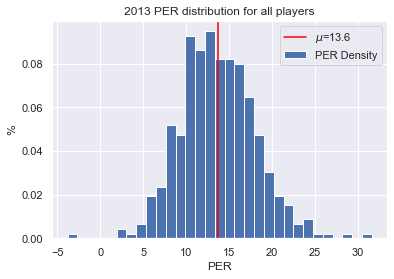

In [10]:
plt.hist(df['PER'], bins=31, density=True, label='PER Density')
plt.axvline(df['PER'].mean(), color='red', label='$\mu$'+'={:.1f}'.format(df['PER'].mean()))
plt.xlabel('PER')
plt.ylabel('%')
plt.title(f'{year} PER distribution for all players')
plt.legend()
plt.show()

In [11]:
max_per = df[df['PER'] == df['PER'].max()].squeeze()
print('Player with maximum PER for year {} is {} with PER of {}'.format(year, max_per['Player'], max_per['PER']))
print('MVP for year {} is {}'.format(year, mvp_dict[year]))

Player with maximum PER for year 2013 is LeBron James with PER of 31.6
MVP for year 2013 is LeBron James


This suggests that indeed the MVP is correlated to maximum PER, *is that really the case?*
***

Now we will split the data to positions to see if there is any difference

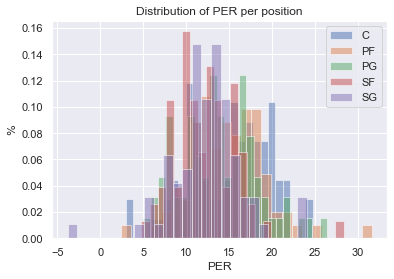

In [12]:
for i, p in enumerate(unique_pos):
    plt.hist(df[df['Pos']==p]['PER'], alpha=0.5, label=p, bins=25, density=True, color=current_palette[i])
plt.xlabel('PER')
plt.ylabel('%')
plt.title('Distribution of PER per position')
plt.legend()
plt.show()

Assuming Normal distribution - Let's find the $\Theta=(\mu , \sigma)$ parameters for each position

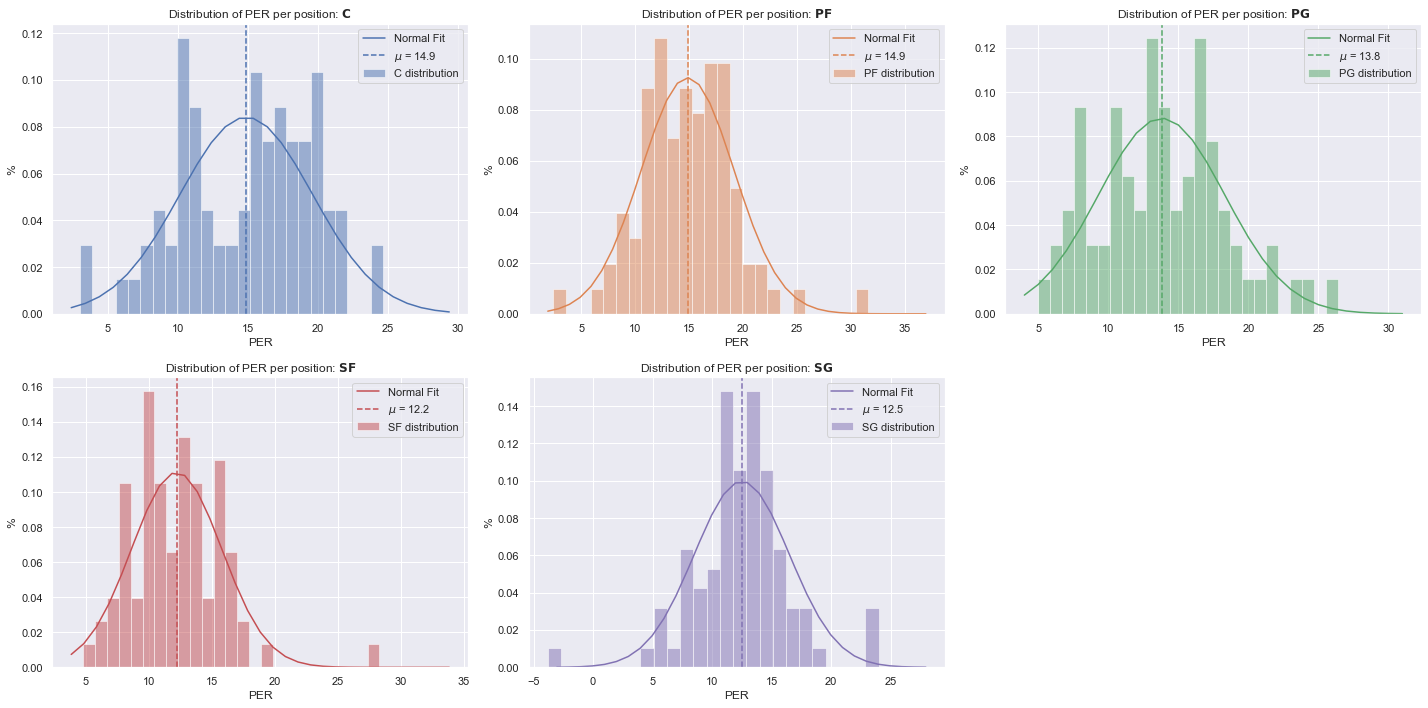

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i,p in enumerate(unique_pos):
    d = df[df['Pos']==p]['PER']
    x_axis = np.arange(np.min(d)*0.8, np.max(d)*1.2, 1)
    ax = axes[i//3][i%3]
    ax.plot(x_axis, scipy.stats.norm.pdf(x_axis,np.mean(d),np.std(d)), color=current_palette[i], label='Normal Fit')
    ax.hist(d, alpha=0.5, label=f'{p} distribution', bins=25, density=True, color=current_palette[i])
    ax.axvline(d.mean(), linestyle='--', color=current_palette[i], label='$\mu$ = {:.1f}'.format(d.mean()))
    ax.legend()
    ax.set_xlabel('PER')
    ax.set_ylabel('%')
    ax.set_title(f'Distribution of PER per position: ' + r"$\bf{" + p + "}$")
    
axes[-1, -1].axis('off')
fig.tight_layout()
plt.show()


We can see from the plots above that the PER has different statistics accross positions!


So it will not be very accurate to assess a player's contribution only by his PER againt all positions, *right*?
***
***

### Positional-PER (pPER): New approach for selecting MVP
Let's investigate our new metric (pPER) and compare to the PER

We will estimate $\mu , \sigma$ for each position -- The more that player is outstanding in his position - he will be chosen as the *aMVP*

In [14]:
def std_dist(per, mean_per, std_per):
    return (per-mean_per)/std_per

def add_pPER_2_db(db, year, pos, μ=None, σ=None):
    df1 = db.loc[(db['Year'] == year) & (db['Pos'] == pos)].copy()
    if μ==None: μ = df1['PER'].mean()
    if σ==None: σ = df1['PER'].std()
    df1.loc[:, 'pPER'] = std_dist(df1['PER'], μ, σ)
    db.loc[df1.index, 'pPER'] = df1['pPER']
    return 

def get_max_stat(df, stat):
    max_stat = df.loc[df[stat] == df[stat].max(), ['Player','PER','pPER']].squeeze()
    return max_stat


#### Naive pPER exploration

In this method we will look at the data for the required season and compare each player against all players in his position. 

In [15]:
dbb = data_fetcher.create_database((year, year+1))
print (f"\033[4mYear: {year}\033[0m")
max_per_pos_dict = {}
for i, p in enumerate(unique_pos):
    pos_df = dbb.loc[dbb['Pos'] == p].copy()
    max_per_s = pos_df.loc[pos_df['PER'] == pos_df['PER'].max(), ['Player','PER']].squeeze()
    pPER = std_dist(max_per_s['PER'], np.mean(pos_df['PER']), np.std(pos_df['PER']))
    print (f"For position {p}: mean={np.mean(pos_df['PER']):.2f}, std={np.std(pos_df['PER']):.2f}")
    print (f"Player with maximum PER within position is {max_per_s['Player']} with PER = {max_per_s['PER']}")
    print (f'With pPER of \033[1m{pPER:.2f}σ\033[0m')
    max_per_pos_dict[p] = {'Player' : max_per_s['Player'], 'PER' : max_per_s['PER'], 'pPER' : pPER}


Year: 2013
For position C: mean=14.90, std=4.74
Player with maximum PER within position is Brook Lopez with PER = 24.7
With pPER of 2.06σ
For position PF: mean=14.87, std=4.31
Player with maximum PER within position is LeBron James with PER = 31.6
With pPER of 3.88σ
For position PG: mean=13.80, std=4.52
Player with maximum PER within position is Chris Paul with PER = 26.4
With pPER of 2.79σ
For position SF: mean=12.20, std=3.59
Player with maximum PER within position is Kevin Durant with PER = 28.3
With pPER of 4.49σ
For position SG: mean=12.50, std=4.00
Player with maximum PER within position is Dwyane Wade with PER = 24.0
With pPER of 2.88σ


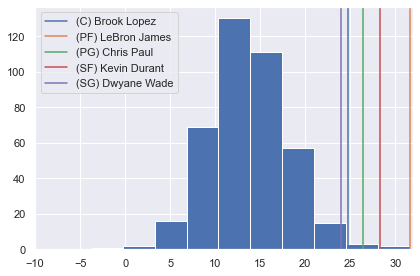

In [16]:
plt.hist(dbb['PER'])
for i,(k,v) in enumerate(max_per_pos_dict.items()):
    plt.axvline(v['PER'], color=current_palette[i], label=f"({k}) {v['Player']}")
plt.xlim(-10,32)
plt.tight_layout()
plt.legend()
plt.show()

WOW ! This is incredicble... Although Kevin Durant has lower PER than LeBron James, when comparing the maximum PER, we can see that he is an exeptional player with respect to his position ($4.5\sigma$)! 

This is pretty innovative!

We can see that in 2013 the Positional PER statistics would have chosen a different MVP (Kevin Durant instead of LeBron James) and therefore it might be the correct statistics to look at when selecting the MVP.
***
***
OK. So we now agree that this method is more accurate. But the question arises now is: Does taking just the $\mu$ and $\sigma$ from current season and current position is good enough? 

Let's try to expand our view and explore how we can utilise our knowledge about the past seasons and infer this on $\mu$ and $\sigma$ for generalized information.

Now, we'll create several models to estimate $\Theta=({\hat{\mu}} , {\hat{\sigma}})$ parameters for each position.

## Finding model parameters
### LR Model for estimating the mean PER vs. Year

Let's see if the PER per position has changed thoughout the years.
We'll do that using Linear Regression. We will compare the results wil null hypothesis is that $\alpha$ = 0, i.e. it has not changed.

In [17]:
years_range = (2007,2020)
dbb = data_fetcher.create_database(years_range)

In [18]:
print(dbb[dbb['MVP']])
dbb.head()

                     Player Pos   PER  Year   MVP
261           Dirk Nowitzki  PF  27.6  2007  True
449             Kobe Bryant  SG  24.2  2008  True
962            LeBron James  SF  31.7  2009  True
1357           LeBron James  SF  31.1  2010  True
1871           Derrick Rose  PG  23.5  2011  True
2144           LeBron James  SF  30.7  2012  True
2538           LeBron James  PF  31.6  2013  True
2876           Kevin Durant  SF  29.8  2014  True
3265          Stephen Curry  PG  28.0  2015  True
3685          Stephen Curry  PG  31.5  2016  True
4400      Russell Westbrook  PG  30.6  2017  True
4577           James Harden  SG  29.8  2018  True
4849  Giannis Antetokounmpo  PF  30.9  2019  True


,Player,Pos,PER,Year,MVP
0,Shareef Abdur-Rahim,C,13.1,2007,False
1,Hassan Adams,SG,13.0,2007,False
2,Maurice Ager,SG,2.9,2007,False
3,LaMarcus Aldridge,C,17.1,2007,False
4,Malik Allen,PF,10.4,2007,False


### Naive approach (Without dividing into positions)

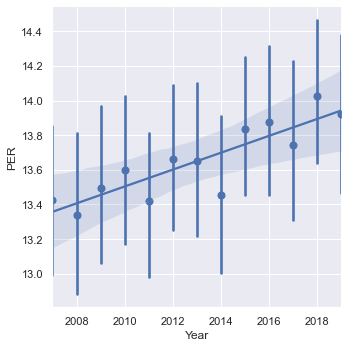

In [19]:
sns.lmplot(
    x='Year', 
    y='PER', 
    data=dbb, 
    x_estimator=np.mean
);

In [20]:
res = scipy.stats.linregress(dbb['Year'], dbb['PER'])
print('slope = {:.3f}, intercept = {:.3f}, P-value = {:.3f}'.format(res.slope, res.intercept, res.pvalue))


slope = 0.049, intercept = -84.513, P-value = 0.004


The P-value gives the probability to get this data if the null hypothesis is correct. In this case, the null hypothesis is $slope=0$.

We can see that indeed there is a linear correlation but let's investigate this per position.

### Advanced approach: Per position mean PER

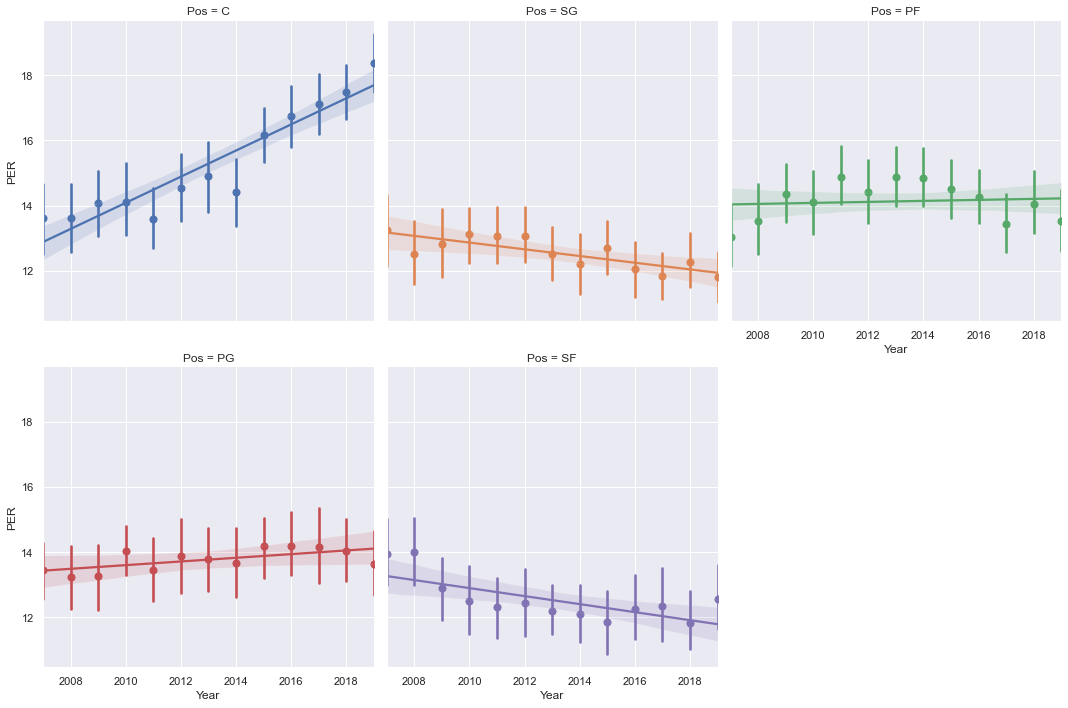

In [21]:
sns.lmplot(
    x='Year', 
    y='PER', 
    data=dbb, 
    x_estimator=np.mean,
    hue='Pos',
    col='Pos', 
    col_wrap=3, 
    sharex=True, 
    sharey=True
);

In [22]:
LR_pos_list = []
for i, pos in enumerate(unique_pos):
    print (f"\033[4mPosition: {pos}\033[0m")
    pos_df = dbb[dbb['Pos']==pos]
    res_pos = scipy.stats.linregress(pos_df['Year'], pos_df['PER'])
    LR_pos_list.append({'Pos':pos,'slope':res_pos.slope,'intercept':res_pos.intercept,}) #'LR-mean':res_pos.slope * np.unique(pos_df['Year']) + res_pos.intercept})
    print('slope = {:.3f}, intercept = {:.2f}, P-value = {:.5f}'.format(res_pos.slope, res_pos.intercept, res_pos.pvalue))

LR_pos_df = pd.DataFrame(LR_pos_list)


Position: C
slope = 0.401, intercept = -792.20, P-value = 0.00000
Position: PF
slope = 0.015, intercept = -16.93, P-value = 0.66237
Position: PG
slope = 0.056, intercept = -99.72, P-value = 0.12633
Position: SF
slope = -0.123, intercept = 260.31, P-value = 0.00142
Position: SG
slope = -0.103, intercept = 219.86, P-value = 0.00179


In [23]:
print("These p-value results suggests that for 'C' position (Centers) the null hypothesis is incorrect (and perhaps also for 'SF' and 'SG'). We can see that in the past {} years the 'C' PER increases by {:.2f} per year, which is incredible!".format(len(range(*years_range)), LR_pos_df.loc[LR_pos_df['Pos']=='C','slope'].squeeze()))


These p-value results suggests that for 'C' position (Centers) the null hypothesis is incorrect (and perhaps also for 'SF' and 'SG'). We can see that in the past 13 years the 'C' PER increases by 0.40 per year, which is incredible!


Now, let's evalute who should be the aMVP (Adjusted MVP) when using the mean value as the Linear Regression mean-PER instead of the current year mean PER for each position.


In [24]:
LR_pos_df

,Pos,slope,intercept
0,C,0.401136,-792.199156
1,PF,0.015431,-16.934720
2,PG,0.056380,-99.724842
3,SF,-0.123090,260.305549
4,SG,-0.102981,219.855025


In [25]:
for pos in unique_pos:
    μ_lr = LR_pos_df.loc[LR_pos_df['Pos']==pos,'slope'].squeeze() * year + LR_pos_df.loc[LR_pos_df['Pos']==pos,'intercept'].squeeze()
    add_pPER_2_db(dbb, year, pos, μ_lr)
    df1 = dbb.loc[dbb['Pos'] == pos].copy()

aMVP_lr_PER = dbb.loc[dbb['pPER'] == dbb['pPER'].max(),'Player'].squeeze()
print('The aMVP when using Linear Regression for the mean-PER estimate is:\n{} with pPER = {:.2f} as opposed to pPER of {:.2f} when using only {} mean'.format(aMVP_lr_PER, dbb['pPER'].max(),[v['pPER'] for k, v in max_per_pos_dict.items() if v['Player'] == aMVP_lr_PER][0],year))



The aMVP when using Linear Regression for the mean-PER estimate is:
Kevin Durant with pPER = 4.37 as opposed to pPER of 4.49 when using only 2013 mean


Using mean value from out linear regression model shows significant shift on all positions. **Kevin Durant's pPER decreased by more than 0.1$\sigma$ !**
***

After evaluting pPER for a single year, we need to calculate the pPER for every player for every year

Calulate the global mean and std.

$\mu_{global}=\frac{1}{N}\cdot\sum_{p\in {P}}{PER_{p}}$

$\sigma_{global}=\sqrt{\frac{1}{N}\cdot{\sum_{p\in {P}}({PER_{p}-\mu_{global}}})^2}$

P = Players in years_range

N = Sum of number of players accross all years_range

In [26]:
μ_global = dbb['PER'].mean()
σ_global = dbb['PER'].std()
print (f'Global PER (accross all years - all players):\nμ_global = {μ_global:.2f}\nσ_global = {σ_global:.2f}')

Global PER (accross all years - all players):
μ_global = 13.65
σ_global = 4.56


In [27]:
def calc_per_mean_per_pos(pos, db):
    return db[db['Pos']==pos]['PER'].mean()

In [28]:
def calc_per_std_per_pos(pos, db):
    return db[db['Pos']==pos]['PER'].std()

In [29]:
μ_years_range = {pos:calc_per_mean_per_pos(pos, dbb) for pos in unique_pos}
σ_years_range = {pos:calc_per_std_per_pos(pos, dbb) for pos in unique_pos}

Example of Shooting-Gaurd ('SG') position in 2013 season:

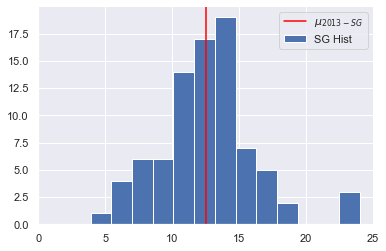

In [79]:
pos, year = 'SG', 2013
one_pos_one_year_d = dbb['PER'][(dbb['Pos']==pos) & (dbb['Year']==year)]
plt.hist(one_pos_one_year_d, bins=18, label='{} Hist'.format(pos))
plt.axvline(μ_years_range[pos], color='red', label='$\mu_{'+'{}-{}'.format(str(year),pos)+'}$')
plt.xlim(0,25)
plt.legend()
sns.despine()
plt.show()

### Bayesian Inference Single Parameter Estimation: Uniform prior

Using Bayesian inferece we will try to estimating the $\mu$ parameter while assuming $\sigma$ is constant based on past data.

In [31]:
def log_likelihood(θ, X):
    μ, σ = θ
    return scipy.stats.norm(μ, σ).logpdf(X).sum()

In [32]:
def log_prior_2d_uni(μ):
    if μ > 0:
        return 0
    else:
        return -np.inf
    
def log_posterior_2d_uni(μ, X):
    pri = log_prior_2d_uni(μ)
    if np.isinf(pri): 
        return pri
    return pri + log_likelihood((μ, σ_global), X)

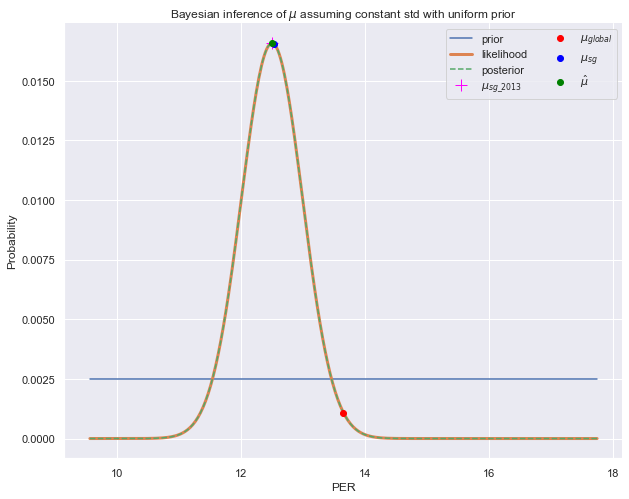

In [33]:
μ_range = np.linspace(μ_global*0.70, μ_global*1.3, 400)

pri = np.exp([log_prior_2d_uni(μ_) for μ_ in μ_range])
lik = np.exp([log_likelihood((μ_, σ_global), one_pos_one_year_d) for μ_ in μ_range])
post = np.exp([log_posterior_2d_uni(μ_, one_pos_one_year_d) for μ_ in μ_range])

μ_hat = μ_range[post.argmax()] # MAP

fig = plt.figure(figsize=((10,8)))
plt.plot(μ_range, pri/pri.sum(), label='prior')
plt.plot(μ_range, lik/lik.sum(), lw=3, label='likelihood')
plt.plot(μ_range, post/post.sum(), ls='--', label='posterior')
plt.plot(one_pos_one_year_d.mean(), np.exp(log_posterior_2d_uni(one_pos_one_year_d.mean(), one_pos_one_year_d))/post.sum(), '+', color='magenta', label='$μ_{'+pos.lower()+'\_'+str(year)+'}$', markersize=12)

plt.plot(μ_global, np.exp(log_posterior_2d_uni(μ_global, one_pos_one_year_d))/post.sum(), 'o', color='red', label='$μ_{global}$')
plt.plot(μ_years_range[pos], np.exp(log_posterior_2d_uni(μ_years_range[pos], one_pos_one_year_d))/post.sum(), 'o', color='blue', label='$μ_{'+pos.lower()+'}$')
plt.plot(μ_hat, np.exp(log_posterior_2d_uni(μ_hat, one_pos_one_year_d))/post.sum(), 'o', color='green', label='$\hat{μ}$')

plt.xlabel("PER")
plt.ylabel("Probability")
plt.title(f'Bayesian inference of $\mu$ assuming constant std with uniform prior')
plt.legend(ncol=2)
sns.despine()

We can see that the $\mu_{global}$ which refers to the data accross all positions / all years does not align well with the posterior, but the mean value for the same position ('SG') across all years looks closer.

Of course, as the theory suggests, $\hat{\mu}$ and the mean value of the data, $\mu_{sg\_2017}$ , results with the same, and maximum postirior
***

### Bayesian Inference Single Parameter Estimation: Normal prior

Now let's find a better prior. Becasue we already saw that the data is distributed normaly, we can assume ~$N(\mu_{global},1)$

In [34]:
class BayesSingleParameterNormal():
    def __init__(self, df_1year_1pos, μ_global, σ_global, pos='SG', year=2017):
        self.df = df_1year_1pos
        self.μ_global = μ_global
        self.σ_global = σ_global
        self.pos = pos
        self.year = year
        pass
    
    def log_prior_2d_norm(self, μ):
        if μ > 0:
            return scipy.stats.norm(self.μ_global, 1).logpdf(μ)
        else:
            return -np.inf

    def log_likelihood(self, θ, X):
        μ, σ = θ
        return scipy.stats.norm(μ, σ).logpdf(X).sum()

    def log_posterior_2d_norm(self, μ, X):
        pri = self.log_prior_2d_norm(μ)
        if np.isinf(pri): 
            return pri
        return pri + self.log_likelihood((μ, self.σ_global), X)

    def estimate_model_params(self):
        self.μ_range = np.linspace(self.μ_global*0.70, self.μ_global*1.3, 400)

        self.pri = np.exp([self.log_prior_2d_norm(μ_) for μ_ in μ_range])
        self.lik = np.exp([self.log_likelihood((μ_, self.σ_global), self.df) for μ_ in μ_range])
        self.post = np.exp([self.log_posterior_2d_norm(μ_, self.df) for μ_ in μ_range])

        self.μ_hat = μ_range[self.post.argmax()] # MAP
        return self.μ_hat

    def plot_results(self):
        fig = plt.figure(figsize=((10,8)))
        plt.plot(self.μ_range, self.pri/self.pri.sum(), label='prior')
        plt.plot(self.μ_range, self.lik/self.lik.sum(), lw=3, label='likelihood')
        plt.plot(self.μ_range, self.post/self.post.sum(), ls='--', label='posterior')
        plt.plot(self.df.mean(), np.exp(self.log_posterior_2d_norm(self.df.mean(), self.df))/self.post.sum(), '+', color='magenta', label='$μ_{'+pos.lower()+'\_'+str(year)+'}$', markersize=12)

        plt.plot(self.μ_global, np.exp(self.log_posterior_2d_norm(self.μ_global, self.df))/self.post.sum(), 'o', color='red', label='$μ_{global}$')
        plt.plot(μ_years_range[self.pos], np.exp(self.log_posterior_2d_norm(μ_years_range[self.pos], self.df))/self.post.sum(), 'o', color='blue', label='$μ_{'+self.pos.lower()+'}$')
        plt.plot(self.μ_hat, np.exp(self.log_posterior_2d_norm(self.μ_hat, self.df))/self.post.sum(), 'o', color='green', label='$\hat{μ}$'+'={:.1f}'.format(self.μ_hat))

        plt.xlabel("PER")
        plt.ylabel("Probability")
        plt.title('Bayesian inference of $\mu$ assuming constant std with norm prior ~$N(\mu_{global},1)$')
        plt.legend(ncol=2)
        sns.despine()


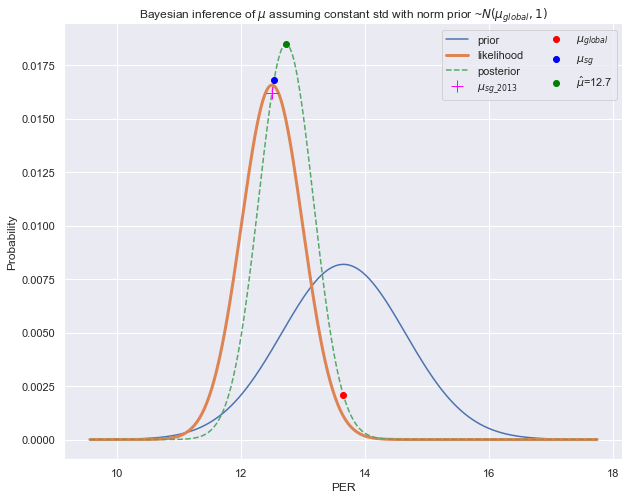

In [35]:
Bayes1Norm = BayesSingleParameterNormal(one_pos_one_year_d, μ_global, σ_global, pos, year)
Bayes1Norm_μ_hat = Bayes1Norm.estimate_model_params()
Bayes1Norm.plot_results()

With normal ditribuition prior, we can see that the posterior results are moving toward the normal prior peak, and that makes a lot of sense since each data point will get higher probability when closer to the prior max PDF.

These results looks more realistic, because it also takes into account the results from past 15 years.

### Bayesian Inference Two Parameters Estimation: Uniform prior

Now let's make it more complicated, we will try to estimate both the $\mu$ and the $\sigma$. 

Starting with uniform prior.

In [36]:
# Becasue we will need to run these function accross all grid, we will C++ compile them with numba
@numba.jit(forceobj=True)
def log_likelihood(θ, X):
    μ, σ = θ
    return scipy.stats.norm(μ, σ).logpdf(X).sum()

In [37]:
@numba.jit(forceobj=True)
def log_prior_3d_uni(θ):
    μ, σ = θ
    if μ > 0 and σ > 0:
        return 0
    else:
        return (-np.inf)
    
@numba.jit(forceobj=True)    
def log_posterior_3d_uni(θ, X):
    pri = log_prior_3d_uni(θ)
    if np.isinf(pri): 
        return pri
    return pri + log_likelihood(θ, X)

In [38]:
μ_range = np.linspace(μ_global*0.70, μ_global*1.3, 100)
σ_range = np.linspace(σ_global*0.60, σ_global*1.4, 100)

X, Y = np.meshgrid(μ_range, σ_range)

In [39]:
pri_grid_uni = np.empty([len(μ_range), len(σ_range)])
lik_grid_uni = np.empty([len(μ_range), len(σ_range)])
post_grid_uni = np.empty([len(μ_range), len(σ_range)])

for μi, μ_ in enumerate(μ_range):
    for σi, σ_ in enumerate(σ_range):
        pri_grid_uni[σi][μi] = np.exp(log_prior_3d_uni((μ_, σ_)))
        lik_grid_uni[σi][μi] = np.exp(log_likelihood((μ_, σ_), one_pos_one_year_d))
        post_grid_uni[σi][μi] = np.exp(log_posterior_3d_uni((μ_, σ_), one_pos_one_year_d))

In [40]:
σ_hat_idx, μ_hat_idx = np.unravel_index(post_grid_uni.argmax(), post_grid_uni.shape)
μ_hat, σ_hat = μ_range[μ_hat_idx], σ_range[σ_hat_idx]
μ_pos, σ_pos = one_pos_one_year_d.mean(), one_pos_one_year_d.std()

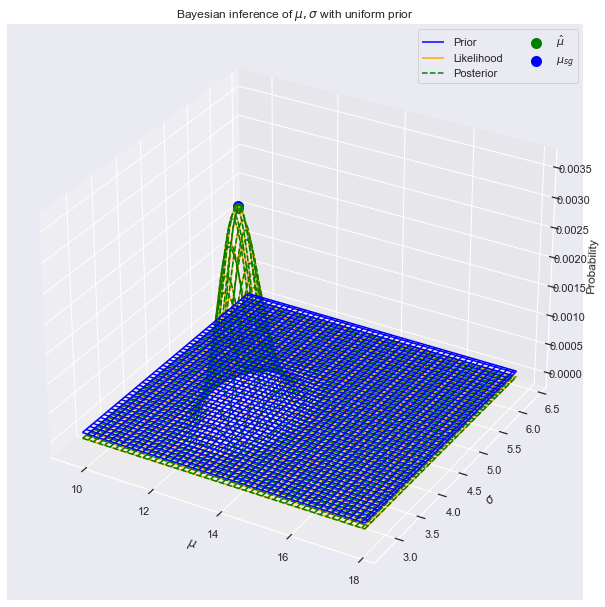

In [41]:
fig = plt.figure(figsize=((10,8)))
ax = Axes3D(fig)
ax.plot_wireframe(X, Y, (pri_grid_uni/pri_grid_uni.sum()),  color='blue', label='Prior')
ax.plot_wireframe(X, Y, (lik_grid_uni/lik_grid_uni.sum()),  color='orange', label='Likelihood')
ax.plot_wireframe(X, Y, (post_grid_uni/post_grid_uni.sum()), color='green', linestyle='--', label='Posterior')

ax.scatter([μ_hat], [σ_hat], [np.exp(log_posterior_3d_uni((μ_hat, σ_hat), one_pos_one_year_d))/post_grid_uni.sum()], s=100, color='green', label='$\hat{μ}$')
ax.scatter([μ_pos], [σ_pos], [np.exp(log_posterior_3d_uni((μ_pos, σ_pos), one_pos_one_year_d))/post_grid_uni.sum()], s=100, color='blue', label='$μ_{'+pos.lower()+'}$')

ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
ax.set_zlabel('Probability')
ax.set_title(f'Bayesian inference of $\mu,\sigma$ with uniform prior')

ax.legend(ncol=2)

plt.show()

In [42]:
print (f'μ_hat x σ_hat cordinates = ({μ_hat:.2f}, {σ_hat:.2f}, {np.exp(log_posterior_3d_uni((μ_hat, σ_hat), one_pos_one_year_d))/post_grid_uni.sum():.6f})')
print (f'μ_pos x σ_pos coordinates = ({μ_pos:.2f}, {σ_pos:.2f}, {np.exp(log_posterior_3d_uni((μ_pos, σ_pos), one_pos_one_year_d))/post_grid_uni.sum():.6f})')


μ_hat x σ_hat cordinates = (12.54, 3.99, 0.003535)
μ_pos x σ_pos coordinates = (12.50, 4.02, 0.003541)


We can see that also here the ML and MAP estimation are also aligned because also here we are using the uniform prior for both $\mu$ and $\sigma$

***
### Bayesian Inference Two Parameters Estimation: Normal prior

Let's take it one more step with normal prior $\mu$ ~ $N(\mu_{global},1)$ and  $\sigma$ ~ $N(\sigma_{global}, 1)$ as we did for the single parameter estimation but now we wil also include the STD. 

That will give us better estimation in order to perform pPER calculations

In [80]:
μ_σ_cov = np.cov([dbb['PER'][dbb['Year']==y].mean() for y in range(*years_range)], [dbb['PER'][dbb['Year']==y].std() for y in range(*years_range)])[0][1]
cov_mtrx=np.array([[1,μ_σ_cov], [μ_σ_cov, 1]])

array([[1.        , 0.01492367],
       [0.01492367, 1.        ]])

Because there $\mu$ and $\sigma$ are dependant ($cov(\mu,\sigma)\neq0$) we will use multivariate distribution.
Create a covariance matrix with VAR=1 for both $\mu$ and $\sigma$ with calculated covariance

In [44]:
@numba.jit(forceobj=True)
def log_prior_3d_norm(θ):
    μ, σ = θ
    if μ > 0 and σ > 0:
        return scipy.stats.multivariate_normal([μ_global, σ_global], cov_mtrx).logpdf([μ, σ])
    else:
        return -np.inf

@numba.jit(forceobj=True)
def log_posterior_3d_norm(θ, X):
    pri = log_prior_3d_norm(θ)
    if np.isinf(pri): 
        return pri
    return pri + log_likelihood(θ, X)

In [45]:
pri_grid_norm = np.empty([len(μ_range), len(σ_range)])
lik_grid_norm = np.empty([len(μ_range), len(σ_range)])
post_grid_norm = np.empty([len(μ_range), len(σ_range)])

for μi, μ_ in enumerate(μ_range):
    for σi, σ_ in enumerate(σ_range):
        pri_grid_norm[σi][μi] = np.exp(log_prior_3d_norm((μ_, σ_)))
        lik_grid_norm[σi][μi] = np.exp(log_likelihood((μ_, σ_), one_pos_one_year_d))
        post_grid_norm[σi][μi] = np.exp(log_posterior_3d_norm((μ_, σ_), one_pos_one_year_d))

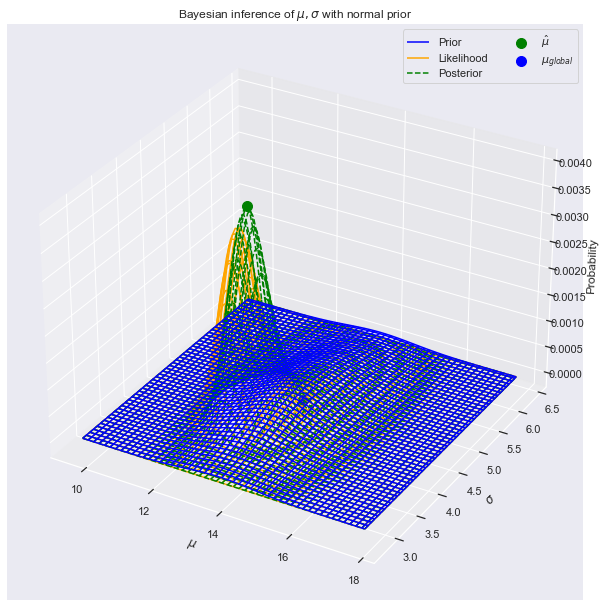

In [46]:
fig = plt.figure(figsize=((10,8)))
ax = Axes3D(fig)
ax.plot_wireframe(X, Y, (pri_grid_norm/pri_grid_norm.sum()),  color='blue', label='Prior')
ax.plot_wireframe(X, Y, (lik_grid_norm/lik_grid_norm.sum()),  color='orange', label='Likelihood')
ax.plot_wireframe(X, Y, (post_grid_norm/post_grid_norm.sum()), color='green', linestyle='--', label='Posterior')

σ_idx, μ_idx = np.unravel_index(post_grid_norm.argmax(), post_grid_norm.shape)
σ_hat, μ_hat = σ_range[σ_idx], μ_range[μ_idx]

ax.scatter([μ_hat], [σ_hat], [np.exp(log_posterior_3d_norm((μ_hat, σ_hat), one_pos_one_year_d))/post_grid_norm.sum()], s=100, color='green', label='$\hat{μ}$')
ax.scatter([μ_global], [σ_global], [np.exp(log_posterior_3d_norm((μ_global, σ_global), one_pos_one_year_d))/post_grid_norm.sum()], s=100, color='blue', label='$μ_{global}$')

ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
ax.set_zlabel('Probability')
ax.set_title(f'Bayesian inference of $\mu,\sigma$ with normal prior')

ax.legend(ncol=2)

plt.show()

In [47]:
print (f'μ_hat x σ_hat cordinates = ({μ_hat:.2f}, {σ_hat:.2f}, {np.exp(log_posterior_3d_norm((μ_hat, σ_hat), one_pos_one_year_d))/post_grid_norm.sum():.6f})')
print (f'μ_pos x σ_pos coordinates = ({μ_pos:.2f}, {σ_pos:.2f}, {np.exp(log_posterior_3d_norm((μ_pos, σ_pos), one_pos_one_year_d))/post_grid_norm.sum():.6f})')
print (f'μ_global x σ_global coordinates = ({μ_global:.2f}, {σ_global:.2f}, {np.exp(log_posterior_3d_norm((μ_global, σ_global), one_pos_one_year_d))/post_grid_norm.sum():.8f})')


μ_hat x σ_hat cordinates = (12.70, 4.06, 0.003920)
μ_pos x σ_pos coordinates = (12.50, 4.02, 0.003517)
μ_global x σ_global coordinates = (13.65, 4.56, 0.00013576)


As expected, similarily to the results that we saw for the single parameter, the posterior moves toward the prior in both $\mu$ and $\sigma$ axes.

$\hat{\mu}$ was estimated similar to the single parameter estimation.

In addition, the $\hat{\sigma}$ was estimated similar to the $\sigma_{pos}$ which is the STD for that position accross all years.

***
## MCMC 3d

Now let's try to estimate the model parameters $\Theta=(\mu,\sigma)$ using Markov Chain Monte Carlo (MCMC) approach

In [98]:
ndim = 2
nwalkers = 50
nsteps  = 10000 // nwalkers
nburn = nsteps // 2

guesses = np.random.rand(nwalkers, ndim)
guesses[:, 0] *= 50  # start mu between 0 and 2000
guesses[:, 1] *= 20    # start sigma between 0 and 20

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_3d_norm, args=[one_pos_one_year_d])
sampler.run_mcmc(guesses, nsteps)

sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)

In [99]:
μ_sample, σ_sample = sample[:,0], sample[:,1]
μ_hat, σ_hat = μ_sample.mean(), (σ_sample).mean()

In [100]:
μ_hat, σ_hat

(12.695520600164343, 4.133393345845482)

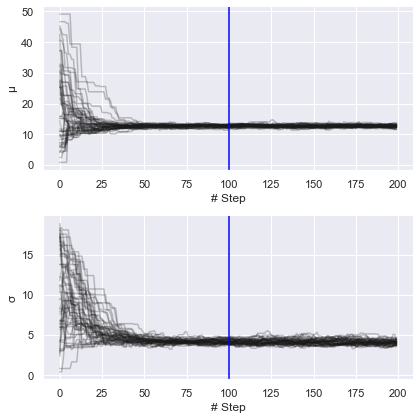

In [101]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6))

for i, varname in enumerate(['μ', 'σ']):
    ax = axes[i]
    ax.plot(sampler.chain[:,:,i].T, color='k', alpha=0.25);
    ax.axvline(nburn, color='blue')
    ax.set_ylabel(varname)
    ax.set_xlabel('# Step')

fig.tight_layout()
sns.despine()

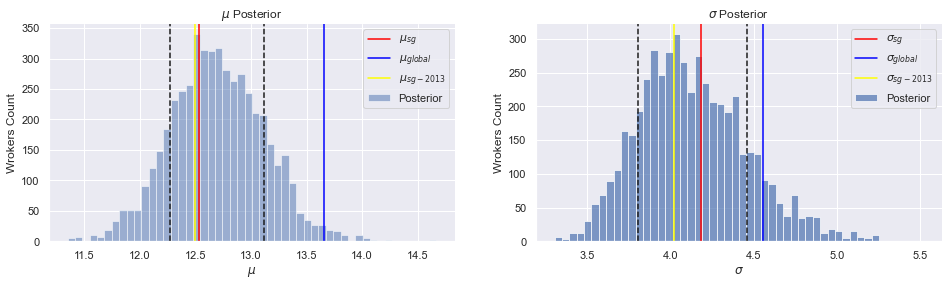

In [103]:
μ_pos_year, σ_pos_year = one_pos_one_year_d.mean(), one_pos_one_year_d.std()

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

axes[0].hist(sample[:,0], bins=50, alpha=0.5, label='Posterior')
axes[0].axvline(μ_years_range[pos], color='red', label=r'$μ_{'+pos.lower()+'}$')
axes[0].axvline(μ_global, color='blue', label=r'$μ_{global}$')
axes[0].axvline(μ_pos_year, color='yellow', label='$μ_{'+pos.lower()+'-'+str(year)+'}$')
axes[0].axvline(μ_hat+sample[:,0].std(), color='k', ls='--')
axes[0].axvline(μ_hat-sample[:,0].std(), color='k', ls='--')
axes[0].set_xlabel("$\mu$")
axes[0].set_ylabel("Wrokers Count")
axes[0].set_title(r'$\mu$ Posterior')
axes[0].legend()

axes[1].hist(sample[:,1], bins=50, alpha=0.7, label='Posterior')
axes[1].axvline(σ_years_range[pos], color='red', label=r'$σ_{'+pos.lower()+'}$')
axes[1].axvline(σ_global, color='blue', label=r'$σ_{global}$')
axes[1].axvline(σ_pos_year, color='yellow', label='$σ_{'+pos.lower()+'-'+str(year)+'}$')
axes[1].axvline(σ_hat+sample[:,1].std(), color='k', ls='--')
axes[1].axvline(σ_hat-sample[:,1].std(), color='k', ls='--')
axes[1].set_xlabel("$\sigma$")
axes[1].set_ylabel("Wrokers Count")
axes[1].set_title(r'$\sigma$ Posterior')
axes[1].legend()


sns.despine()

Using MCMC we can see that the posterior mean is pretty close to the SG-2017 data for both $\mu, \sigma$ withing 1-STD limit of the workers hist

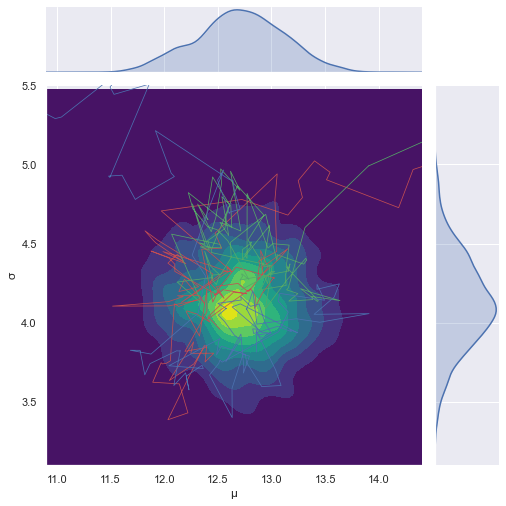

In [84]:
g = sns.jointplot(
    sampler.chain[:, nburn :, 0].ravel(), 
    sampler.chain[:, nburn:, 1].ravel(), 
    kind='kde', cmap='viridis', height=7, 
    xlim=(10.9, 14.4), ylim=(3.1,5.5))
g.set_axis_labels('μ', 'σ')

for i, c in enumerate('rgb'):
    g.ax_joint.plot(sampler.chain[i, :, 0], sampler.chain[i, :, 1], lw=0.75, color=c)
    

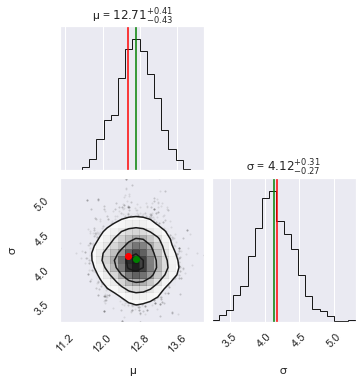

In [54]:
cor = corner(sample, 
    smooth=True,
    labels=['μ', 'σ'],
    show_titles=True,
)
cor.axes[0].axvline(μ_years_range[pos], color='red', label=r'$μ_{'+pos.lower()+'}$')
cor.axes[3].axvline(σ_years_range[pos], color='red', label=r'$μ_{'+pos.lower()+'}$')
cor.axes[2].plot(μ_years_range[pos], σ_years_range[pos], 'o', color='red', label=r'$μ_{'+pos.lower()+'}$')

cor.axes[0].axvline(μ_hat, color='green')
cor.axes[3].axvline(σ_hat, color='green')
cor.axes[2].plot(μ_hat, σ_hat, 'o', color='green')

plt.show()

***
### Scipy optimization using fmin

Now we will try to estimate the model parameters with maximizing the log likelihood (e.g minimizing the neg_log_likelihood)

In [55]:
def neg_log_likelihood(θ, X):
    return -log_likelihood(θ, X)

θ_hat, θ_path =scipy.optimize.fmin(
    func=neg_log_likelihood, 
    x0=(μ_global*1.4, σ_global*0.60), 
    args=(one_pos_one_year_d,),
    retall=1
)
θ_path = np.array(θ_path)
θ_hat

Optimization terminated successfully.
         Current function value: 238.432919
         Iterations: 40
         Function evaluations: 79


array([12.50000448,  3.99948418])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


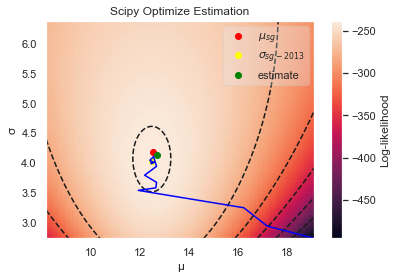

In [56]:
μ_range = np.linspace(μ_global*0.60, μ_global*1.4, 100)
σ_range = np.linspace(σ_global*0.60, σ_global*1.4, 100)
ll = np.array([
    [log_likelihood((μ_, σ_), one_pos_one_year_d) for μ_ in μ_range]
    for σ_ in σ_range
])

im = plt.pcolormesh(μ_range, σ_range, ll)
plt.contour(μ_range, σ_range, ll, colors='k')
plt.colorbar(im, label='Log-likelihood')
plt.plot(μ_years_range[pos], σ_years_range[pos], 'o', color='red', label=r'$μ_{'+pos.lower()+'}$')
plt.plot(μ_pos_year, σ_pos_year, 'o', color='yellow', label='$σ_{'+pos.lower()+'-'+str(year)+'}$')
plt.plot(μ_hat, σ_hat, 'o', color='green', label='estimate')
plt.plot(θ_path[:,0], θ_path[:,1], '-', color='blue')
plt.xlabel('μ')
plt.ylabel('σ')
plt.legend(framealpha=0.3)
plt.title ('Scipy Optimize Estimation')
plt.show()

In [57]:
print (f'μ_hat , σ_hat = {μ_hat:.2f}, {σ_hat:.2f}')
print (f'μ_pos , σ_pos = {μ_pos:.2f}, {σ_pos:.2f}')
print (f'μ_global , σ_global = {μ_global:.2f}, {σ_global:.2f}')

μ_hat , σ_hat = 12.71, 4.13
μ_pos , σ_pos = 12.50, 4.02
μ_global , σ_global = 13.65, 4.56


***
### ABC

ABC (Approximate Bayesian Computation) is a likelihood free approach that uses simulations to approximate the posterior. 

Together with Monte Carlo approach that we used before (MCMC), we wil use the Sequential Monte Carlo sampler (ABC SMC).

This method is generating samples ("particles"), and performs a series of steps similar to MCMC to move them around the parameter space.

This step creates a new population that will now move to the next itteration.

The algorithm will stop once it reaches to distance below the $\epsilon$ or number of maximum population has been reached (N).

In [58]:
import pyabc

In [85]:
N = 2000 # Experiments
n = 100 # Samples per experiment
ϵ = 1 # Acceptance rate: ρ* <= ϵ
μ_year_pos = one_pos_one_year_d.mean()
σ_year_pos = one_pos_one_year_d.std()

We will use the same priors:

$\mu$ ~ $N(\mu_{global},1)$

$\sigma$ ~ $N(\sigma_{global}, 1)$

In [86]:
priors = pyabc.Distribution(
    μ = pyabc.RV("norm", μ_global, 1),
    σ = pyabc.RV("norm", σ_global, 1)
)
priors.rvs()

<Parameter 'μ': 13.699006185281489, 'σ': 3.190503205169122>

In [87]:
def simulator(μ, σ, n=1):
    """μ, σ: parameters
       n: number of samples
    """
    μ, σ = np.atleast_1d(μ, σ)
    F = scipy.stats.norm(μ, σ).rvs(size=(n, μ.size))
    X_sim = scipy.stats.poisson(np.maximum(F, 0)).rvs()
    return X_sim.T

def summary(X):
    X = np.atleast_2d(X)
    S1 = X.mean(axis=1)
    S2 = X.std(axis=1, ddof=1)
    return np.array([S1, S2])

def distance(simulation, data):
    return (
        np.abs(data['S1'] - simulation['S1']) +
        np.abs(data['S2'] - simulation['S2'])
    )[0]

def model(parameters):
    X = simulator(parameters['μ'], parameters['σ'], n=n)
    S1, S2 = summary(X).squeeze()
    return dict(S1=S1, S2=S2)

observation = dict(S1=np.array([μ_year_pos]), S2=np.array([σ_year_pos]))

distance(model(priors.rvs()), observation)

4.934294151228231

In [88]:
abc = pyabc.ABCSMC(
    model, 
    priors, 
    distance,
    population_size=N, 
    # you can try to remove the next line and see if multicore sampler (the default) works
    sampler=pyabc.SingleCoreSampler()
)

In [89]:
db_path = "sqlite:///pyabc_nba.db"

In [90]:
abc.new(db_path, observation)

INFO:History:Start <ABCSMC(id=11, start_time=2020-08-30 21:07:29.562938, end_time=None)>


In [91]:
history = abc.run(minimum_epsilon=ϵ)

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 3.092923983578325
INFO:ABC:t: 0, eps: 3.092923983578325.
INFO:ABC:Acceptance rate: 2000 / 3936 = 5.0813e-01, ESS=2.0000e+03.
INFO:ABC:t: 1, eps: 2.192736321665648.
INFO:ABC:Acceptance rate: 2000 / 4792 = 4.1736e-01, ESS=1.2685e+03.
INFO:ABC:t: 2, eps: 1.6524779164510026.
INFO:ABC:Acceptance rate: 2000 / 5375 = 3.7209e-01, ESS=1.4780e+03.
INFO:ABC:t: 3, eps: 1.256430921608498.
INFO:ABC:Acceptance rate: 2000 / 6655 = 3.0053e-01, ESS=1.0233e+03.
INFO:ABC:t: 4, eps: 0.9524679870574911.
INFO:ABC:Acceptance rate: 2000 / 7955 = 2.5141e-01, ESS=1.1757e+03.
INFO:ABC:Stopping: minimum epsilon.
INFO:History:Done <ABCSMC(id=11, start_time=2020-08-30 21:07:29.562938, end_time=2020-08-30 21:08:55.498234)>


In [92]:
abc.load(db_path, history.id) # load from file
history = abc.history

history.total_nr_simulations

30713

In [93]:
samples, weights = history.get_distribution(m=0)
μ_sample, σ_sample = samples['μ'], samples['σ']
μ_hat, σ_hat = np.average(μ_sample, weights=weights), np.average(σ_sample, weights=weights)

print("μ_pos_year = {} \tμ_hat = {:.2f}\nσ_pos_year = {}\t\tσ_hat = {:.2f}".format(
    μ_year_pos, μ_hat, σ_year_pos, σ_hat))

μ_pos_year = 12.5 	μ_hat = 12.79
σ_pos_year = 4.023176901523518		σ_hat = 3.01


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pyabc/visualization/kde.py:350: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh = ax.pcolormesh(X, Y, PDF, **kwargs)


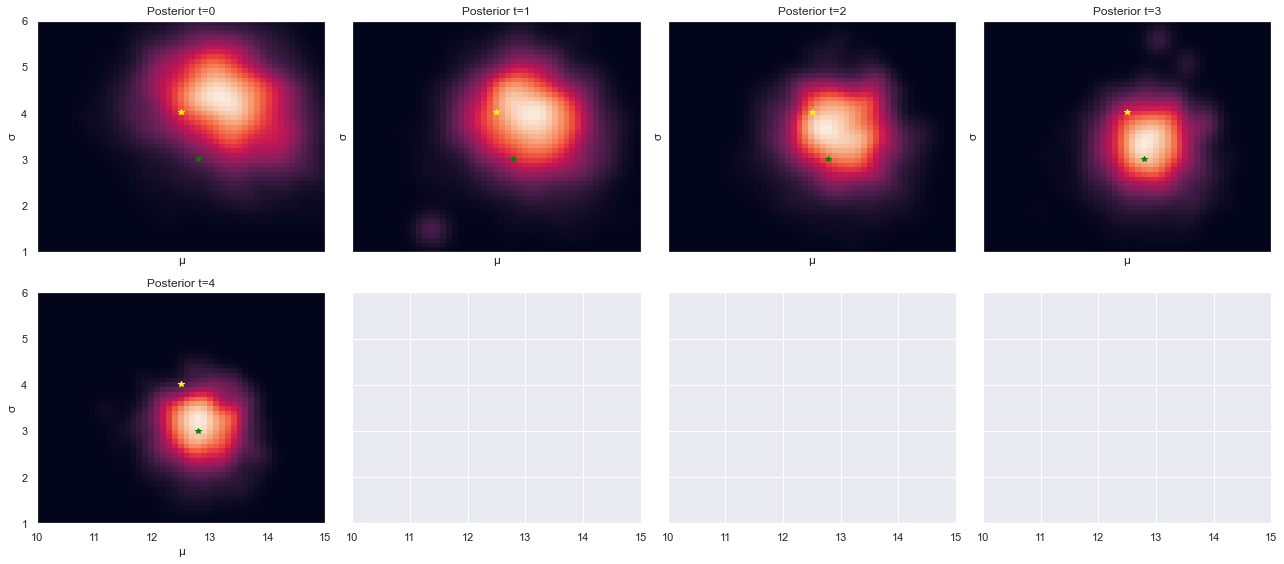

In [94]:
fig, axes = plt.subplots(history.max_t//4+1, 4, figsize=(18, 8), sharex=True, sharey=True)
for t in range(history.max_t + 1):
    ax = axes.flat[t]
    samples_, weights_ = history.get_distribution(m=0, t=t)
    pyabc.visualization.plot_kde_2d(
        samples_, weights_, "μ", "σ",
        xmin=10, xmax=15, ymin=1, ymax=6, colorbar=False, ax=ax)
    ax.plot(μ_year_pos, σ_year_pos, '*', color='yellow')
    ax.plot(μ_hat, σ_hat, '*', color='green')
    ax.set_title("Posterior t={}".format(t))
fig.tight_layout()

In [95]:
def plot_history(history):
    fig, axes = plt.subplots(1,2,  figsize=(18, 4))
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=9, xmax=17,
                                       x='μ', ax=axes[0],
                                       label="PDF t={}".format(t))
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=6,
                                       x='σ', ax=axes[1],
                                       label="PDF t={}".format(t))
    axes[0].axvline(μ_year_pos, color='k', linestyle='dashed', label='$μ_{'+pos.lower()+'-'+str(year)+'}$')
    axes[1].axvline(σ_year_pos, color='k', linestyle='dashed', label='$σ_{'+pos.lower()+'-'+str(year)+'}$')
    axes[0].legend()
    axes[1].legend()
    axes[0].set_title('μ')
    axes[1].set_title('σ')

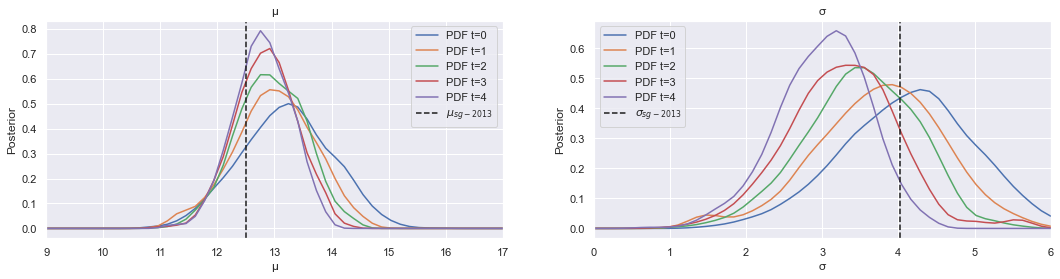

In [96]:
plot_history(history)

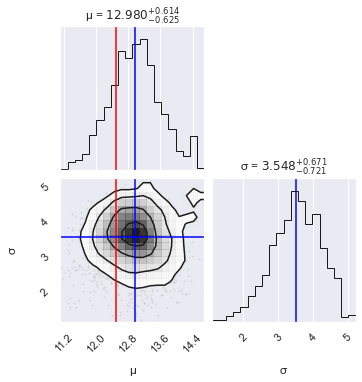

In [71]:
cor = corner(samples, 
    weights=weights,
    title_fmt='.3f', 
    smooth=True,
    show_titles=True,
    truths=(one_pos_one_year_d.mean(), μ_hat, one_pos_one_year_d.std()),
    truth_color='red'
)
cor.axes[0].axvline(μ_hat, color='blue')
cor.axes[3].axvline(σ_hat, color='blue')
cor.axes[2].axvline(μ_hat, color='blue')
cor.axes[2].axhline(σ_hat, color='blue')
plt.show()

We can see that for the $\mu$ value the ABC MSC converges from the initial mean to toward the data value ($μ_{sg\_2017}$) while the $\sigma$ seems to take diffrent direction.

Therefore, we decided not to take this approach in out evaluation.
***
***

## Model Evalution of Positional-PER using Bayesian Inference Single Parameter Estimation (Normal prior)


We've selected to evalute the pPER using the Bayesian Inference Single Parameter with Normal prior as the estimation results fits best to our task.


During our development of the model we used a single position (SG).

Let's infer the $\Theta = (\hat{\mu},\hat{\sigma}=\sigma_{global}) $ parameters for each position and evalute the pPER with regards to the infered parameters.

In [72]:
print('We will use μ_global = {:.2f}, σ_global = {:.2f}'.format(μ_global, σ_global))
print("Let's evalute the {} season".format(year))

We will use μ_global = 13.65, σ_global = 4.56
Let's evalute the 2013 season


In [73]:

for pp in unique_pos:
    df_1year_1pos = dbb.loc[(dbb['Year']==year) & (dbb['Pos']==pp),'PER']
    Bayes1Norm = BayesSingleParameterNormal(df_1year_1pos, μ_global, σ_years_range[pp], pp, year)   
    Bayes1Norm_μ_hat = Bayes1Norm.estimate_model_params()
    add_pPER_2_db(dbb, year, pp, μ=Bayes1Norm_μ_hat, σ=σ_years_range[pp])



C : 14.592847079423777
PF : 14.703189968493145
PG : 13.820446855938208
SF : 12.496332187105807
SG : 12.71701796524454


In [74]:

def find_candidates_df(df):
    mvp_winner = df.loc[df['MVP'],['Player','PER','pPER']].squeeze().to_dict()
    mvp_winner['Award'] = 'MVP Winner'
    max_per = get_max_stat(df, 'PER').to_dict()
    max_per['Award'] = 'Max PER'
    max_pper = get_max_stat(df, 'pPER').to_dict()
    max_pper['Award'] = 'Max pPER'
    df_Candidates = pd.DataFrame([mvp_winner, max_per, max_pper])
    columns_titles = ['Award', 'Player','PER', 'pPER']
    df_Candidates = df_Candidates.reindex(columns=columns_titles)
    return df_Candidates
        
def analyse_mvp_award(db, years=[], verbose=True):
    if not years:
        years = np.unique(db['Year'])
    for year in years:
        print (f"\033[4mYear: {year}\033[0m")
        db_sliced = db[db['Year'] == year]
        df_Candidates = find_candidates_df(db_sliced)
        if verbose:
            if df_Candidates['Player'][0] != df_Candidates['Player'][1]: # MVP doesn't match MaxPER
                ccolor = 'red'
                print(colored("MVP doesn't match Max PER", ccolor))
            elif df_Candidates['Player'][1] != df_Candidates['Player'][2]: # MaxPER doesn't match MaxaPER
                ccolor = 'magenta'
                print(colored("Max PER doesn't match Max pPER", ccolor))
            else:
                ccolor = 'grey'
                print(colored("All figure of merit match!", ccolor))
            print(colored(df_Candidates, ccolor))
            print("="*55)
            

#### Single year (2013) evalution

In [75]:
analyse_mvp_award(dbb, [year])

Year: 2013
All figure of merit match!
        Award        Player   PER      pPER
0  MVP Winner  LeBron James  31.6  3.881884
1     Max PER  LeBron James  31.6  3.881884
2    Max pPER  LeBron James  31.6  3.881884


We can see that although LeBron James won the MVP award, perhaps it should have gone to Kevin Durant, as he was the most dominant player with respect to his position on the floor.

Let's see if this occurs in other years as well

#### Comparison of MVP vs. aMVP 

In [76]:
def model_eval_yearly(year):    
    for pp in np.unique(dbb['Pos']):
        df_1year_1pos = dbb.loc[(dbb['Year']==year) & (dbb['Pos']==pp),'PER']
        Bayes1Norm = BayesSingleParameterNormal(df_1year_1pos, μ_global, σ_years_range[pp], pp, year)

        Bayes1Norm_μ_hat = Bayes1Norm.estimate_model_params()
        add_pPER_2_db(dbb, year, pp, μ=Bayes1Norm_μ_hat)

In [77]:
for y in range(*years_range):
    model_eval_yearly(y)

In [78]:
analyse_mvp_award(dbb)


Year: 2007
MVP doesn't match Max PER
        Award         Player   PER      pPER
0  MVP Winner  Dirk Nowitzki  27.6  3.176439
1     Max PER    Dwyane Wade  28.9  3.026515
2    Max pPER  Dirk Nowitzki  27.6  3.176439
Year: 2008
MVP doesn't match Max PER
        Award        Player   PER      pPER
0  MVP Winner   Kobe Bryant  24.2  2.466028
1     Max PER  LeBron James  29.1  3.535521
2    Max pPER    Chris Paul  28.3  3.686127
Year: 2009
All figure of merit match!
        Award        Player   PER     pPER
0  MVP Winner  LeBron James  31.7  4.40385
1     Max PER  LeBron James  31.7  4.40385
2    Max pPER  LeBron James  31.7  4.40385
Year: 2010
All figure of merit match!
        Award        Player   PER      pPER
0  MVP Winner  LeBron James  31.1  4.165327
1     Max PER  LeBron James  31.1  4.165327
2    Max pPER  LeBron James  31.1  4.165327
Year: 2011
MVP doesn't match Max PER
        Award        Player   PER      pPER
0  MVP Winner  Derrick Rose  23.5  2.191376
1     Max PER  LeBron

***
***
### Conclusions

The pPER figure of merit shows a dominance of a player with regards to his position on the floor, compared to fellow players on the same position.

Based on the analysis we have seen based on PER metric only, it seems to be good fit with MVP for most years.

Nevertheles, the pPER figure of merit, we believe, indicates best the player which shall be elected to be the Most Valuable Player or at least used as a reference for the voters.



![](https://media.tenor.com/images/0fa6dd9284076642cfcd8e7d3c1a29fa/tenor.gif)